# setting up imports

In [ ]:
# !unzip /content/benchmark_data.zip
# !unzip /content/data_4s.zip

In [ ]:
# !mv data_4s/test_hidden/S1/* data_4s/test_hidden
# !mv data_4s/test_hidden/S9/* data_4s/test_hidden

In [ ]:
# Install a compatible version of TensorFlow, e.g., 2.8 or higher
# !pip install tensorflow==2.8.0

# # Install the other required packages
# !pip install mne>=0.17.1 PyRiemann>=0.2.5 scikit-learn>=0.20.1 matplotlib>=2.2.3

# !pip install --upgrade tensorflow


In [ ]:
# Clone the repository (replace the URL with the correct one if needed)
# !git clone https://github.com/vlawhern/arl-eegmodels.git

# Navigate to the cloned directory
%cd arl-eegmodels


[Errno 2] No such file or directory: 'arl-eegmodels'
/content/arl-eegmodels/arl-eegmodels


In [ ]:
import sys
sys.path.append('/content/arl-eegmodels')
# import google.colab.drive
# google.colab.drive.mount('/content/drive')


# Data Loading

For the EEGModels project, the expected input data type is EEG (Electroencephalography) signal data, typically represented as a 3D array with the following structure:

1. **Samples/Trials (N):** The number of individual EEG recordings or trials in the dataset. Each sample represents an independent recording or a segment of an EEG signal.
2. **Channels (Chans):** The number of EEG electrodes or channels used in the recordings. Common EEG systems use configurations with 32, 64, or 128 channels, representing different scalp locations where EEG signals are measured.
3. **Time Points/Samples (Samples):** The number of time points or samples per EEG channel. It represents the length of the EEG recording in terms of discrete time steps. For example, if the EEG signal was recorded for 1 second at a sampling rate of 128 Hz, the number of time points would be 128.

### Expected Shape of the Data
The input data should have the shape `(N, Chans, Samples)`, where:
- `N` is the number of samples (trials or recordings),
- `Chans` is the number of EEG channels,
- `Samples` is the number of time points in each recording.

### Example Data Shape
- **Shape:** `(100, 64, 128)`
  - **100 samples:** There are 100 individual trials/recordings.
  - **64 channels:** The EEG system uses 64 electrodes.
  - **128 time points:** Each trial is 1 second long at a sampling rate of 128 Hz.

### Labels for Classification
The expected output labels for classification tasks are typically categorical labels representing different classes. For binary classification (e.g., detecting a specific mental state), you might use `0` and `1` as class labels. For multiclass problems, the labels can be integers representing different categories (e.g., different cognitive tasks or conditions).

### Data Preprocessing
- **Normalization:** EEG data often needs to be normalized, typically channel-wise.
- **Reshaping:** Ensure the data is in the correct format `(N, Chans, Samples)`.
- **One-Hot Encoding:** Convert labels to one-hot encoding if using categorical cross-entropy loss.

If the data is not already segmented, you may need to preprocess it into smaller chunks (trials) for training the models.

In [ ]:
# import os
# import numpy as np
# from scipy.io import loadmat
# from scipy.signal import cheby1, filtfilt, resample
# from tensorflow.keras.utils import to_categorical

# def chebyshev_bandpass(lowcut, highcut, fs, order=4, rp=0.5):
#     """
#     Design a Chebyshev Type I bandpass filter.

#     Parameters:
#     - lowcut: Low frequency cut-off for the bandpass filter.
#     - highcut: High frequency cut-off for the bandpass filter.
#     - fs: Sampling frequency of the EEG data.
#     - order: The order of the filter (default: 4).
#     - rp: Maximum ripple in the passband (default: 0.5 dB).

#     Returns:
#     - b, a: Numerator (b) and denominator (a) polynomials of the filter.
#     """
#     nyquist = 0.5 * fs
#     low = lowcut / nyquist
#     high = highcut / nyquist
#     b, a = cheby1(order, rp, [low, high], btype='band')
#     return b, a

# def load_benchmark_data(data_dir, n_channels=64, n_timepoints=1500, n_classes=40,
#                   lowcut=6.0, highcut=90.0, fs=1000, target_fs=250,
#                   window_length=250):
#     """
#     Load EEG data from .mat files in a directory, apply Chebyshev bandpass filter,
#     downsample, segment with sliding window, and return as arrays.

#     Parameters:
#     - data_dir: Directory containing .mat files.
#     - n_channels: Number of EEG channels (default: 64).
#     - n_timepoints: Number of time points per trial (default: 1500).
#     - n_classes: Number of target classes (default: 40).
#     - lowcut: Low frequency cut-off for Chebyshev bandpass filter (default: 6 Hz).
#     - highcut: High frequency cut-off for Chebyshev bandpass filter (default: 90 Hz).
#     - fs: Original sampling frequency of the EEG data (default: 1000 Hz).
#     - target_fs: Target sampling frequency after downsampling (default: 250 Hz).
#     - window_length: Length of each segment window in samples (default: 250 samples for 1s at 250 Hz).

#     Returns:
#     - X: EEG data as a NumPy array with shape (N, Chans, Samples).
#     - y: One-hot encoded labels as a NumPy array.
#     """
#     X, y = [], []
#     b, a = chebyshev_bandpass(lowcut, highcut, fs, order=4)  # Define Chebyshev filter

#     # Iterate through each .mat file in the directory
#     for file_name in os.listdir(data_dir):
#         if file_name.endswith('.mat'):
#             file_path = os.path.join(data_dir, file_name)
#             mat_data = loadmat(file_path)

#             # Assuming data is stored in 'data' variable with shape [64, 1500, 40, 6]
#             eeg_data = mat_data['data']  # Shape: [64, 1500, 40, 6]

#             # Process each trial
#             for target_idx in range(eeg_data.shape[2]):
#                 for block_idx in range(eeg_data.shape[3]):
#                     trial_data = eeg_data[:, :, target_idx, block_idx]  # Shape: [64, 1500]

#                     # Apply bandpass filter
#                     trial_data_filtered = np.zeros_like(trial_data)
#                     for ch in range(n_channels):
#                         trial_data_filtered[ch, :] = filtfilt(b, a, trial_data[ch, :])

#                     # Downsample to target sampling rate
#                     trial_data_downsampled = resample(trial_data_filtered, int(trial_data_filtered.shape[1] * target_fs / fs), axis=1)

#                     # Apply sliding window to generate segments
#                     for start in range(0, trial_data_downsampled.shape[1] - window_length + 1, window_length):
#                         segment = trial_data_downsampled[:, start:start + window_length]

#                         # Normalize segment channel-wise
#                         segment = (segment - segment.mean(axis=1, keepdims=True)) / segment.std(axis=1, keepdims=True)

#                         # Append the segment and label
#                         X.append(segment)
#                         y.append(target_idx)  # Label as the target index

#     # Convert lists to NumPy arrays
#     X = np.array(X)  # Shape: [num_samples, 64, window_length]
#     y = np.array(y)  # Shape: [num_samples]

#     # Convert labels to one-hot encoding
#     y = to_categorical(y, num_classes=n_classes)
#     print(X.shape)
#     print(y.shape)
#     return X, y


# def load_beta_data(data_dir, n_channels=64, n_classes=40,
#                   lowcut=6.0, highcut=90.0, fs=250, target_fs=250,
#                   window_length=250):
#     """
#     Load EEG data from .mat files in a directory, apply Chebyshev bandpass filter,
#     downsample, segment with sliding window, and return as arrays.

#     Parameters:
#     - data_dir: Directory containing .mat files.
#     - n_channels: Number of EEG channels (default: 64).
#     - n_classes: Number of target classes (default: 40).
#     - lowcut: Low frequency cut-off for Chebyshev bandpass filter (default: 6 Hz).
#     - highcut: High frequency cut-off for Chebyshev bandpass filter (default: 90 Hz).
#     - fs: Original sampling frequency of the EEG data (default: 1000 Hz).
#     - target_fs: Target sampling frequency after downsampling (default: 250 Hz).
#     - window_length: Length of each segment window in samples (default: 250 samples for 1s at 250 Hz).

#     Returns:
#     - X: EEG data as a NumPy array with shape (N, Chans, Samples).
#     - y: One-hot encoded labels as a NumPy array.
#     """
#     X, y = [], []
#     b, a = chebyshev_bandpass(lowcut, highcut, fs, order=4)  # Define Chebyshev filter
#     i = 0
#     # Iterate through each .mat file in the directory
#     for file_name in os.listdir(data_dir):
#         if file_name.endswith('.mat'):
#             file_path = os.path.join(data_dir, file_name)
#             print(i)
#             mat_data = loadmat(file_path)

#             # Assuming data is stored in 'data' variable with shape [64, 1500, 40, 6]
#             eeg_data = ((mat_data['data'])['EEG'])[0,0].transpose((0,1,3,2))  # Shape: [64, 750, 40, 6]

#             # Process each trial
#             for target_idx in range(eeg_data.shape[2]):
#                 for block_idx in range(eeg_data.shape[3]):
#                     trial_data = eeg_data[:, :, target_idx, block_idx]  # Shape: [64, 1500]

#                     # Apply bandpass filter
#                     trial_data_filtered = np.zeros_like(trial_data)
#                     for ch in range(n_channels):
#                         trial_data_filtered[ch, :] = filtfilt(b, a, trial_data[ch, :])

#                     # Downsample to target sampling rate
#                     trial_data_downsampled = resample(trial_data_filtered, int(trial_data_filtered.shape[1] * target_fs / fs), axis=1)

#                     # Apply sliding window to generate segments
#                     for start in range(0, trial_data_downsampled.shape[1] - window_length + 1, window_length):
#                         segment = trial_data_downsampled[:, start:start + window_length]

#                         # Normalize segment channel-wise
#                         segment = (segment - segment.mean(axis=1, keepdims=True)) / segment.std(axis=1, keepdims=True)

#                         # Append the segment and label
#                         X.append(segment)
#                         y.append(target_idx)  # Label as the target index

#         i += 1

#     # Convert lists to NumPy arrays
#     X = np.array(X)  # Shape: [num_samples, 64, window_length]
#     y = np.array(y)  # Shape: [num_samples]

#     # Convert labels to one-hot encoding
#     y = to_categorical(y, num_classes=n_classes)
#     print(X.shape)
#     print(y.shape)
#     return X, y



In [ ]:
from tqdm import tqdm
import os
import numpy as np
import tensorflow as tf

def load_all_data_to_memory(data_dir, num_classes=40):
    """
    Load all .npy files from the directory into memory with a progress bar.

    Parameters:
    - data_dir: Directory containing the .npy files.
    - num_classes: Total number of classes.

    Returns:
    - X: NumPy array of all data.
    - Y: One-hot encoded labels.
    """
    file_paths = [os.path.join(data_dir, f) for f in os.listdir(data_dir) if f.endswith('.npy')]
    data_list = []
    label_list = []

    # Use tqdm to display the progress
    for file_path in tqdm(file_paths, desc="Loading data", unit="file"):
        data = np.load(file_path, allow_pickle=True).item()
        data_list.append(data['data'])  # EEG data
        label_list.append(data['label'] - 1)  # Adjust label to 0-indexed

    X = np.array(data_list, dtype=np.float32)
    Y = tf.keras.utils.to_categorical(label_list, num_classes=num_classes).astype(np.float32)
    return X, Y


In [ ]:
import gc
gc.collect()

from sklearn.model_selection import train_test_split

# Load and preprocess benchmark data
# data_dir = '/content/drive/MyDrive/11785-IDL-Project-Team19/data'
# data_dir = '/content/benchmark_data'
# x, y = load_benchmark_data(data_dir)

train_dir = '/content/data_4s/train'
x_train, y_train = load_all_data_to_memory(train_dir)

val_dir = '/content/data_4s/val'
x_val, y_val = load_all_data_to_memory(val_dir)

test_1_dir = '/content/data_4s/test'
x_test_1, y_test_1 = load_all_data_to_memory(test_1_dir)

test_2_dir = '/content/data_4s/test_hidden'
x_test_2, y_test_2 = load_all_data_to_memory(test_2_dir)


# Load and preprocess beta data
# data_dir = '/content/drive/MyDrive/11785-IDL-Project-Team19/data_beta'
# data_dir = '/content/data_beta'
# X, y = load_beta_data(data_dir) # for 3s data
# X, y = load_beta_data(data_dir, n_timepoints=1000) # for 4s data
# Split into training and validation sets
# x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=42)
# Preprocess EEG Data

Loading data: 100%|██████████| 480/480 [00:00<00:00, 8760.41file/s]


In [ ]:
config = {
    "lr":          1E-3,
    "batch_size":  128,
    "num_workers": 8,
    "num_epochs":  100,
    "num_classes": 40,
    "apply_freq_mask": False,
    "freq_mask_width_range": 5,
    "num_freq_mask": 1,
    "apply_time_mask": False,
    "time_mask_width_range": 10,
    "num_time_mask": 1,
    "apply_phase_noise": False,
    "phase_noise_std_dev": 0.05,
    "phase_noise_prob": 0.1,
    "apply_mag_noise": True,
    "mag_noise_std_dev": 0.01,
    "mag_noise_prob": 0.1,
    "apply_rand_impulse": False,
    "impulse_mag_max": 0.05,
    "impulse_delay_max": 5,
    "impulse_max_num": 1,
    "apply_sp_noise": False,
    "sp_noise_std_dev": 0.005,
    "sp_noise_prob": 0.1
}

In [ ]:
import tensorflow as tf

class EEGDataLoader(tf.keras.utils.Sequence):

  def __init__(self, features, transcripts, config, is_train):
    self.config = config
    self.features = features
    self.transcripts = transcripts
    self.is_train = is_train
    self.batch_size = self.config['batch_size']
    self.length = transcripts.shape[0] // self.batch_size

  def __len__(self):
    return self.length

  def __getitem__(self, idx):

    batch_features = self.features[idx * self.batch_size:(idx + 1) * self.batch_size,:,:]
    batch_transcripts = self.transcripts[idx * self.batch_size:(idx + 1) * self.batch_size]

    if self.is_train:

      if self.config['apply_rand_impulse']:
        for i in range(len(batch_features)):
          freq_feature = np.fft.fft(batch_features[i])

          conv_mask = np.zeros_like(batch_features[i])
          conv_mask[:,0] = np.ones_like(conv_mask[:,0])

          for j in range(self.config['impulse_max_num']):
            if np.random.random() < 0.5:
              index = np.random.randint(0, conv_mask.shape[1])
              magnitude = np.random.rand() * self.config['impulse_mag_max']
              conv_mask[:,index] = magnitude * np.ones_like(conv_mask[:,index])

          freq_mult_mask = np.fft.fft(conv_mask)

          freq_feature = freq_feature * freq_mult_mask

          batch_features[i] = np.fft.ifft(freq_feature)


      if self.config['apply_phase_noise']:
        for i in range(len(batch_features)):
          freq_feature = np.fft.fft(batch_features[i])
          phase = np.angle(freq_feature)
          magnitude = np.abs(freq_feature)

          gaussian_noise = np.random.normal(0, self.config['phase_noise_std_dev'], (phase.shape[0],phase.shape[1] // 2)) * (np.random.rand(phase.shape[0],phase.shape[1] // 2) < self.config['phase_noise_prob'])
          phase_0 = phase[:,0:phase.shape[1] // 2] + gaussian_noise
          phase = np.concatenate((phase_0,-np.fliplr(phase_0)),axis=1)

          freq_feature = magnitude * np.exp(1j * phase)

          batch_features[i] = np.fft.ifft(freq_feature)


      if self.config['apply_mag_noise']:
        for i in range(len(batch_features)):
          freq_feature = np.fft.fft(batch_features[i])
          phase = np.angle(freq_feature)
          magnitude = np.abs(freq_feature)

          gaussian_noise = np.random.normal(0, self.config['mag_noise_std_dev'], (magnitude.shape[0],magnitude.shape[1] // 2))
          magnitude_0 = magnitude[:,0:magnitude.shape[1] // 2] + gaussian_noise
          magnitude = np.max(np.concatenate((magnitude_0,np.fliplr(magnitude_0)), axis=1),0)

          freq_feature = magnitude * np.exp(1j * phase)

          batch_features[i] = np.fft.ifft(freq_feature)


      if self.config['apply_sp_noise']:
        for i in range(len(batch_features)):
          time_feature = batch_features[i]

          gaussian_noise = np.random.normal(0, self.config['sp_noise_std_dev'], time_feature.shape)
          time_feature = np.max(time_feature + gaussian_noise,0)

          batch_features[i] = time_feature


      if self.config['apply_freq_mask']:
        for i in range(len(batch_features)):
          freq_feature = np.fft.fft(batch_features[i])

          for j in range(self.config['num_freq_mask']):
            window_width = np.random.randint(1, self.config['freq_mask_width_range'])
            start_index = np.random.randint(0,freq_feature.shape[1] // 2 - window_width)
            end_index = start_index + window_width
            length = freq_feature.shape[1]
            freq_feature[:,start_index:end_index] = np.zeros_like(freq_feature[:,start_index:end_index])
            freq_feature[:,length-end_index:length-start_index] = np.zeros_like(freq_feature[:,length-end_index:length-start_index])

          batch_features[i] = np.fft.ifft(freq_feature)


      if self.config['apply_time_mask']:
        for i in range(len(batch_features)):
          time_feature = batch_features[i]

          for j in range(self.config['num_time_mask']):
            if np.random.random() < 0.5:
              window_width = np.random.randint(1, self.config['time_mask_width_range'])
              start_index = np.random.randint(0,time_feature.shape[1] - window_width)
              end_index = start_index + window_width
              time_feature[:,start_index:end_index] = np.zeros_like(time_feature[:,start_index:end_index])

          batch_features[i] = time_feature

    return batch_features, batch_transcripts


  def on_epoch_end(self):
    new_indices = np.random.permutation(np.arange(self.features.shape[0])).astype(np.int32)
    self.features[np.arange(self.features.shape[0]),:,:] = self.features[new_indices,:,:]
    self.transcripts[np.arange(self.features.shape[0])] = self.transcripts[new_indices]

# DATA LOADER

In [ ]:
train_loader = EEGDataLoader(
    features = x_train,
    transcripts = y_train,
    config = config,
    is_train = True
)

val_loader = EEGDataLoader(
    features = x_val,
    transcripts = y_val,
    config = config,
    is_train = False
)

test_1_loader = EEGDataLoader(
    features = x_test_1,
    transcripts = y_test_1,
    config = config,
    is_train = False
)

test_2_loader = EEGDataLoader(
    features = x_test_2,
    transcripts = y_test_2,
    config = config,
    is_train = False
)

## Test Data Loader

In [ ]:
%matplotlib inline

<ipython-input-47-b47cadb9fcd5>:70: ComplexWarning: Casting complex values to real discards the imaginary part
  batch_features[i] = np.fft.ifft(freq_feature)


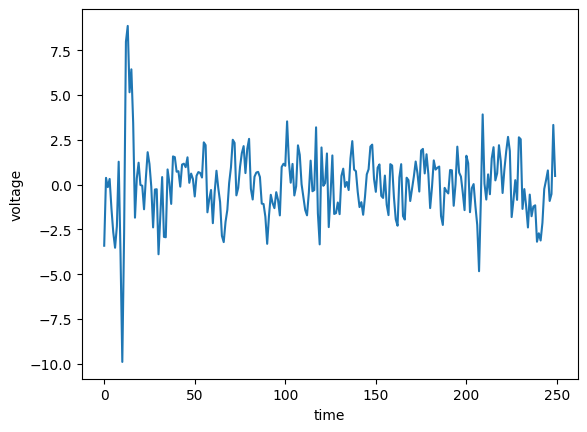

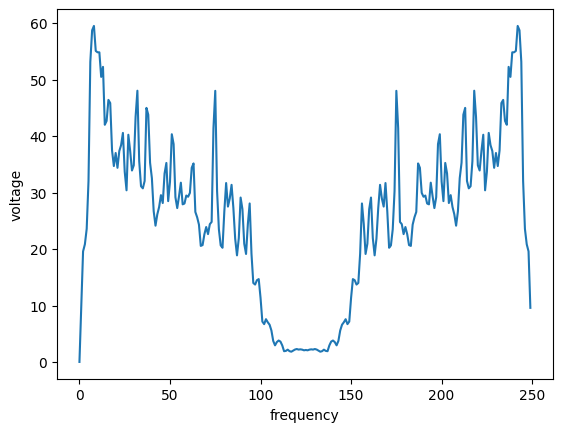

250
(-30.631198716455003+16.5780160035663j)
(-30.631198716455007-16.578016003566304j)


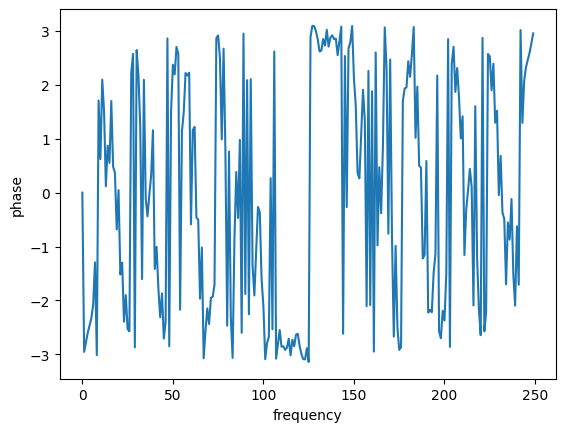

In [ ]:
import matplotlib.pyplot as plt

for batch in train_loader:
  features, transcripts = batch
  feature_0 = features[0]
  plt.plot(feature_0[0,:])
  plt.xlabel('time')
  plt.ylabel('voltage')
  plt.show()

  freq_feature_0 = np.fft.fft(feature_0)
  plt.plot(np.abs(freq_feature_0[0,:]))
  plt.xlabel('frequency')
  plt.ylabel('voltage')
  plt.show()

  print(freq_feature_0.shape[1])
  print(freq_feature_0[0,30])
  print(freq_feature_0[0,freq_feature_0.shape[1]-30])

  freq_feature_0 = np.fft.fft(feature_0)
  plt.plot(np.angle(freq_feature_0[0,:]))
  plt.xlabel('frequency')
  plt.ylabel('phase')
  plt.show()

  break

# MODEL ARCHITECTURE

parametes passed into the EEGNet includes:


1.   **nb_classes**: The number of output classes for classification
2.   **Chans**: The number of EEG channels in your data (i.e., the number of electrodes).This parameter should match the second dimension of your input data shape.
3.   **Samples**: The number of time points per trial. This corresponds to the number of time samples in each EEG segment.

optional parameters include:


1.   **dropoutRate**: The dropout rate for regularization (default is 0.5).
2.   **kernLength**: The length of the convolution kernel (default is 64).
3.   **F1**: Number of temporal filters (default is 8).
4.   **D**: Depth multiplier for the separable convolution (default is 2).
5.     **F2**: Number of spatial filters (default is F1 * D).
6.   **norm_rate**: The dropout fraction for the normalization layer (default is 0.25).









In [ ]:
from EEGModels import EEGNet, ShallowConvNet, DeepConvNet

# Creating an EEGNet model : params include: (for benchmark)
# model = EEGNet(nb_classes=40, Chans=64, Samples=1500, dropoutRate=0.5, kernLength=64, F1=8, D=2, F2=16, dropoutType='Dropout')

# Creating an EEGNet model : params include: (for beta)
model = EEGNet(nb_classes=40, Chans=64, Samples=250, dropoutRate=0.5, kernLength=64, F1=8, D=2, F2=16, dropoutType='Dropout')

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)           │ (None, 64, 250, 1)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 64, 250, 8)          │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_18               │ (None, 64, 250, 8)          │              32 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ depthwise_conv2d_6 (DepthwiseConv2D) │ (None, 1, 250, 16)          │           1,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_19               │ (None, 1, 250, 16)          │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_12 (Activation)           │ (None, 1, 250, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling2d_12                 │ (None, 1, 62, 16)           │               0 │
│ (AveragePooling2D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_12 (Dropout)                 │ (None, 1, 62, 16)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ separable_conv2d_6 (SeparableConv2D) │ (None, 1, 62, 16)           │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_20               │ (None, 1, 62, 16)           │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_13 (Activation)           │ (None, 1, 62, 16)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling2d_13                 │ (None, 1, 7, 16)            │               0 │
│ (AveragePooling2D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_13 (Dropout)                 │ (None, 1, 7, 16)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 112)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 40)                  │           4,520 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ softmax (Activation)                 │ (None, 40)                  │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,728 (26.28 KB)

 Trainable params: 6,648 (25.97 KB)

 Non-trainable params: 80 (320.00 B)

# TRAINING THE MODEL

We use keras framework - so we are going to train using model.fit()


1.   **X_train** = This parameter represents the input training data. It should be a NumPy array or a tensor, with dimensions that match the input shape expected by the model.
2.   **Y_train** = This is the target output (labels) corresponding to the input data X_train. It should be a NumPy array of labels, either one-hot encoded (for categorical classification) or as class integers
3.   **batch_size** = This defines the number of training samples to process before updating the model's weights.
4.  **epochs** = This indicates the number of complete passes through the entire training dataset

5.  **verbose** = This controls the output displayed during training:

*   0: No output (silent mode).
*   1: Displays a progress bar for each epoch.
*   2: Displays one line per epoch with the loss and accuracy.

Using verbose=2 provides a compact summary for each epoch, showing the training metrics without the progress bar.



## Train with Data Loader

In [ ]:
from sklearn.model_selection import KFold
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from tensorflow.keras.initializers import RandomNormal
from EEGModels import EEGNet, ShallowConvNet, DeepConvNet
import gc

gc.collect()

checkpoint = ModelCheckpoint(
    filepath='/content/checkpoints/model-timemask-3-{epoch:02d}-{val_loss:.2f}.h5',
    monitor='val_accuracy',
    save_best_only=False,
    save_weights_only=False,
    mode='max',
    verbose=1
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-6,
    verbose=1
)

# Clear previous model weights (to ensure training from scratch for each fold)
# Creating an EEGNet model : params include:
model = EEGNet(nb_classes=40, Chans=64, Samples=250, dropoutRate=0.2, kernLength=64, F1=16, D=2, F2=32, dropoutType='Dropout')

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=config['lr']), metrics=['accuracy'])

history = model.fit(train_loader, validation_data=val_loader, epochs=config['num_epochs'], batch_size=config['batch_size'], verbose=1,
    callbacks=[checkpoint, lr_scheduler])

# Get the final validation loss and accuracy for this fold
loss = history.history['val_loss'][-1]
accuracy = history.history['val_accuracy'][-1]

print(f"Validation Loss: {loss:.4f}, Validation Accuracy: {accuracy:.4f}")

loss_1, accuracy_1 = model.evaluate(test_1_loader, batch_size=config['batch_size'], verbose=0)
print(f"Vissible Test Loss: {loss_1}")
print(f"Vissible Test Accuracy: {accuracy_1}")

loss_2, accuracy_2 = model.evaluate(test_2_loader, batch_size=config['batch_size'], verbose=0)
print(f"Non-Vissible Test Loss: {loss_2}")
print(f"Non-Vissible Test Accuracy: {accuracy_2}")

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
<ipython-input-47-b47cadb9fcd5>:70: ComplexWarning: Casting complex values to real discards the imaginary part
  batch_features[i] = np.fft.ifft(freq_feature)


Epoch 1/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step - accuracy: 0.0225 - loss: 3.6945
Epoch 1: saving model to /content/checkpoints/model-timemask-3-01-3.68.keras
49/49 ━━━━━━━━━━━━━━━━━━━━ 18s 316ms/step - accuracy: 0.0227 - loss: 3.6941 - val_accuracy: 0.0521 - val_loss: 3.6827 - learning_rate: 0.0010
Epoch 2/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step - accuracy: 0.0665 - loss: 3.4934
Epoch 2: saving model to /content/checkpoints/model-timemask-3-02-3.59.keras
49/49 ━━━━━━━━━━━━━━━━━━━━ 15s 312ms/step - accuracy: 0.0665 - loss: 3.4920 - val_accuracy: 0.0599 - val_loss: 3.5889 - learning_rate: 0.0010
Epoch 3/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step - accuracy: 0.0958 - loss: 3.2671
Epoch 3: saving model to /content/checkpoints/model-timemask-3-03-3.50.keras
49/49 ━━━━━━━━━━━━━━━━━━━━ 15s 310ms/step - accuracy: 0.0959 - loss: 3.2665 - val_accuracy: 0.0911 - val_loss: 3.5034 - learning_rate: 0.0010
Epoch 4/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step - accuracy: 0.1205 - loss: 3.

## Train without Data Loader

In [ ]:
# from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.callbacks import ModelCheckpoint,ReduceLROnPlateau
# from EEGModels import EEGNet

# model = EEGNet(nb_classes=40, Chans=64, Samples=250, dropoutRate=0.2, kernLength=64, F1=16, D=2, F2=32, dropoutType='Dropout')

# checkpoint = ModelCheckpoint(
#     filepath='/content/checkpoints/model-{epoch:02d}-{val_loss:.2f}.keras',
#     monitor='val_accuracy',
#     save_best_only=True,
#     save_weights_only=False,
#     mode='max',
#     verbose=1
# )


# lr_scheduler = ReduceLROnPlateau(
#     monitor='val_loss',
#     factor=0.5,
#     patience=3,
#     min_lr=1e-6,
#     verbose=1
# )

# model.compile(
#     loss='categorical_crossentropy',
#     optimizer=Adam(learning_rate=1e-3),
#     metrics=['accuracy']
# )

# history = model.fit(
#     x_train, y_train,
#     validation_data=(x_val, y_val),
#     batch_size=128,
#     epochs=20,
#     callbacks=[checkpoint, lr_scheduler],
#     verbose=1
# )

# # Get the final validation loss and accuracy for this fold
# loss = history.history['val_loss'][-1]
# accuracy = history.history['val_accuracy'][-1]

# print(f"Validation Loss: {loss:.4f}, Validation Accuracy: {accuracy:.4f}")

# loss_1, accuracy_1 = model.evaluate(test_1_loader, batch_size=config['batch_size'], verbose=0)
# print(f"Vissible Test Loss: {loss_1}")
# print(f"Vissible Test Accuracy: {accuracy_1}")

# loss_2, accuracy_2 = model.evaluate(test_2_loader, batch_size=config['batch_size'], verbose=0)
# print(f"Non-Vissible Test Loss: {loss_2}")
# print(f"Non-Vissible Test Accuracy: {accuracy_2}")

# EVALUATING THE MODEL

The .evaluate() method is used to assess the model’s performance on a validation or test dataset. It returns the loss value and any specified metrics (like accuracy) for the dataset.



In [ ]:
# loss, accuracy = model.evaluate(X_val, y_val, batch_size=32, verbose=2)
# print(f"Validation Loss: {loss}")
# print(f"Validation Accuracy: {accuracy}")


alternatively, we can pass validation data during the model training (it helps regulate overfitting)

The model will evaluate its performance on X_val and y_val after each epoch, and the loss and accuracy will be reported.

This helps track how the model's performance on unseen data evolves over time, which is useful for detecting overfitting early.

Additionally, we can use callbacks like EarlyStopping to stop training if the validation loss does not improve for a specified number of epochs.

In [ ]:
#model.fit(X_train, y_train, batch_size=32, epochs=50, verbose=2, validation_data=(X_val, y_val))


How to use callbacks at model.fit() - [tensorflow.keras.callbacks](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/Callback)

In [ ]:
# from tensorflow.keras.callbacks import EarlyStopping

# early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# model.fit(X_train, y_train, batch_size=32, epochs=50, verbose=2, validation_data=(X_val, y_val), callbacks=[early_stopping])
